**Carga de Sísmica**

*Se vincula con el drive para tomar la sísmica de la carpeta compartida*

Por favor agregar la carpeta compartida llamada "Seismic_Facies" en "Mi Unidad" para poder correr este código

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
filename = '/content/drive/MyDrive/Seismic_Facies/0.dat'

**Instalación y carga de librerías**

In [3]:
!pip install segyio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 2.3 MB/s eta 0:00:00


In [4]:
!python -m pip install "dask[complete]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.2 MB/s eta 0:00:00


In [6]:
import os
import segyio
import sys
import time
import numpy as np


import dask.array as da
import dask.dataframe as ddf

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, List, Tuple, Callable

**Conversión del Cubo a np.array**

In [7]:
def convert2np(ruta_archivo):

    #abre archivo en modo binario
    with open(ruta_archivo, 'rb') as archivo :
        #lee todos los bytes del archivo
        datos_brutos = archivo.read()

    #asume que los datos son float32 (4bytes)
    #tamaño es 1238x128x128x4bytes
    tamaño_total_bytes = 128 * 128 * 128 * 4
    if len(datos_brutos) != tamaño_total_bytes:
        raise ValueError("El tamaño de los datos no coincide con lo esperado")

    #conviertre datos brutos en numpy array
    datos_np = np.frombuffer(datos_brutos, dtype=np.float32)

    #redimensiona el array a 128*128*128
    datos_redimensionados = datos_np.reshape(128,128,128)

    return datos_redimensionados

In [8]:
array_3d  = convert2np(filename)
array_3d.shape

(128, 128, 128)

**Atributos Sísmicos**

*Se extrae de la sísmica los atributos que sean linealmente independientes*

Esta parte del código es extraída del repositiorio [Energy-sdk](https://github.com/otavioon/energy-sdk/blob/master/rapids_seismic_facies/Unsupervised_Seismic_Facies_DGXA100.ipynb)

In [9]:
def run_attributes(input_cube, attributes: List[Tuple[str, Callable, Dict[str, str]]]):
    datas = [attr_func(input_cube, **attr_kwargs).flatten() for _, attr_func, attr_kwargs in attributes]
    datas = da.stack(datas, axis=1)
    return ddf.from_dask_array(datas, columns=[attr_name for attr_name, _, _ in attributes])

In [10]:
import sys
sys.path.append('/content/drive/MyDrive/Seismic_Facies/d2geo')

from attributes.CompleTrace import ComplexAttributes
#from attributes.CompleTrace_kernel import ComplexAttributes
from attributes.SignalProcess import SignalProcess



In [11]:
complex_att = ComplexAttributes()
signal_process = SignalProcess()

In [12]:
def amplitude_arr(input_cube):
    return da.from_array(input_cube)

In [13]:
funcs = [
    ('Amplitude', amplitude_arr, {}),
    ('Envelope', complex_att.envelope, {}),
    ('Instantaneous Phase', complex_att.instantaneous_phase, {}),
    ('Cosine Instantaneous Phase', complex_att.cosine_instantaneous_phase, {}),
    ('Relative Amplitude Change', complex_att.relative_amplitude_change, {}),
    ('Amplitude Acceleration', complex_att.amplitude_acceleration, {}),
    ('Instantaneous Bandwidth', complex_att.instantaneous_bandwidth, {})
]

dataframe = run_attributes(array_3d, funcs).compute()
dataframe.tail()

,Amplitude,Envelope,Instantaneous Phase,Cosine Instantaneous Phase,Relative Amplitude Change,Amplitude Acceleration,Instantaneous Bandwidth
2097147,1.440257,2.302196,51.273666,0.0,-0.536115,-0.475425,0.085325
2097148,-0.502839,1.303523,112.690552,0.0,-0.684071,0.123179,0.108873
2097149,-0.775578,0.934053,146.133255,0.0,-0.289757,0.437127,0.046116
2097150,-0.267029,0.724009,-111.642899,180.0,0.190182,0.292481,0.030268
2097151,0.432669,1.314418,70.781509,0.0,0.295205,0.052511,0.046983


**Gráfica de Atributos**

In [14]:
def grafico_3d(data,name):

    kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(data.min(), data.max(), 10),
}

    #Nx, Ny, Nz = 128,128,128
    Nx, Ny, Nz = np.shape(data)
    X, Y, Z = np.meshgrid(np.arange(Nx), np.arange(Ny), -np.arange(Nz))


    # Create a figure with 3D ax
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')

    # Plot contour surfaces
    _ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], data[:, :, 0],
    zdir='z', offset=0, **kw
    )
    _ = ax.contourf(
    X[0, :, :], data[0, :, :], Z[0, :, :],
    zdir='y', offset=0, **kw
    )
    C = ax.contourf(
    data[:, -1, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
    )
# --


# Set limits of the plot from coord limits
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    zmin, zmax = Z.min(), Z.max()
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
    edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
    ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

    # Set labels and zticks
    ax.set(
    xlabel='X ',
    ylabel='Y ',
    zlabel='Z',
    #zticks=[0, -150, -300, -450],
)

    # Set zoom and angle view
    ax.view_init(20, -60, 0)
    ax.set_box_aspect(None, zoom=0.9)

    ax.set_title(name)

    # Colorbar
    fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Name [units]')

# Show Figure
    plt.show()

In [15]:
amp = amplitude_arr(array_3d)
np.shape(amp)

(128, 128, 128)

In [16]:
env_prueba = complex_att.envelope(array_3d)
np.shape(env_prueba)

(128, 128, 128)

In [17]:
inst_ph_prueba = complex_att.instantaneous_phase(array_3d)
np.shape(inst_ph_prueba)

(128, 128, 128)

In [18]:
cos_ip_prueba = complex_att.cosine_instantaneous_phase(array_3d)
np.shape(cos_ip_prueba)

(128, 128, 128)

In [19]:
rel_amp_change_prueba =  complex_att.relative_amplitude_change(array_3d)
np.shape(rel_amp_change_prueba)

(128, 128, 128)

In [20]:
amplitude_acceleration_prueba =  complex_att.amplitude_acceleration(array_3d)
np.shape(amplitude_acceleration_prueba)

(128, 128, 128)

In [21]:
instantaneous_bandwidth_prueba =complex_att.instantaneous_bandwidth(array_3d)
np.shape(instantaneous_bandwidth_prueba)

(128, 128, 128)

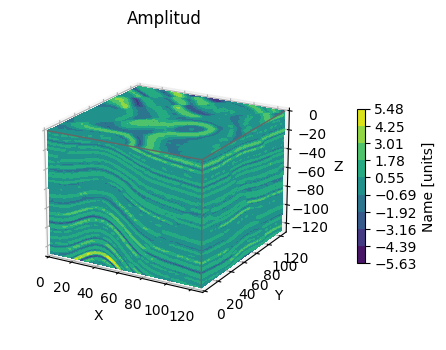

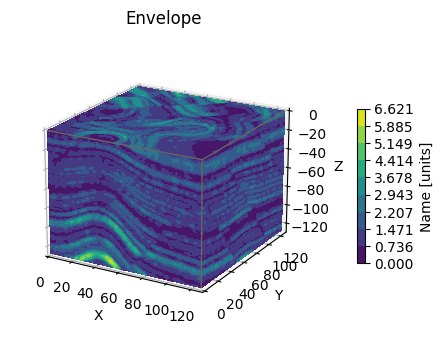

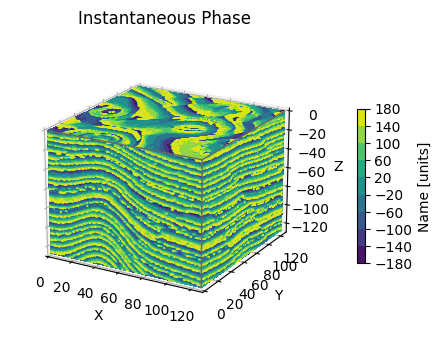

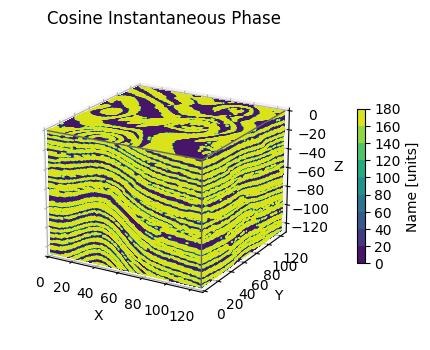

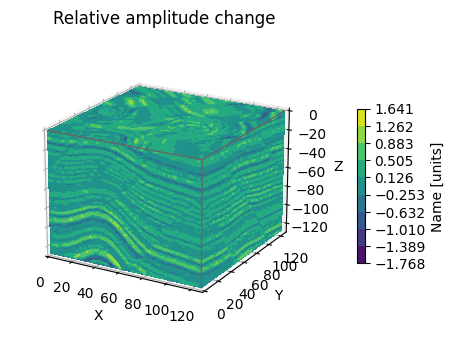

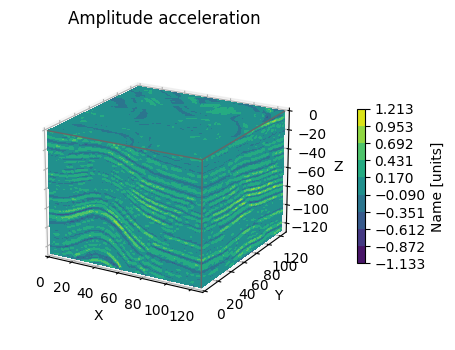

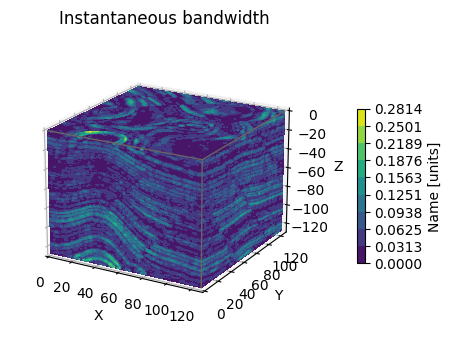

In [24]:
grafico_3d(amp,'Amplitud')
grafico_3d(env_prueba,'Envelope')
grafico_3d(inst_ph_prueba,'Instantaneous Phase')
grafico_3d(cos_ip_prueba,'Cosine Instantaneous Phase')
grafico_3d(rel_amp_change_prueba,'Relative amplitude change')
grafico_3d(amplitude_acceleration_prueba,'Amplitude acceleration')
grafico_3d(instantaneous_bandwidth_prueba,'Instantaneous bandwidth')

In [25]:
dataframe.shape

(2097152, 7)

**Mapas Auto-Organizados (SOM)**

In [26]:
!pip install sklearn_som

In [27]:
from sklearn_som.som import SOM

In [28]:
features = [
'Amplitude','Envelope','Instantaneous Phase',
         'Cosine Instantaneous Phase','Relative Amplitude Change','Amplitude Acceleration',
             'Instantaneous Bandwidth'
]

X = dataframe.loc[:, features].values

In [29]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [31]:
som = SOM(m=1, n=6, dim=len(features), random_state=42)
som.fit(X, epochs=1)

In [32]:
dataframe['facies'] = som.predict(X)

**Cubo Multiatributo**

In [35]:
def grafico_3d_facies(data, name, categorical_variable):
    # Obtener las dimensiones del cubo sísmico
    Nx, Ny, Nz = np.shape(data)
    X, Y, Z = np.meshgrid(np.arange(Nx), np.arange(Ny), -np.arange(Nz))

    # Crear una figura con un eje 3D
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')

    # Aplanar los datos y la variable categórica
    data_flat = data.flatten()
    categorical_variable_flat = categorical_variable.flatten()

    # Colores basados en la variable categórica
    colors = plt.cm.gist_earth(categorical_variable_flat / np.max(categorical_variable_flat))

    # Graficar los puntos en el espacio 3D
    ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=colors, alpha=0.6)

    # Establecer límites de los ejes
    ax.set(xlim=[0, Nx-1], ylim=[0, Ny-1], zlim=[-Nz+1, 0])

    # Establecer etiquetas de los ejes
    ax.set(xlabel='X', ylabel='Y', zlabel='Z')

    # Configurar ángulo de visualización
    ax.view_init(20, -60)

    # Título del gráfico
    ax.set_title(name)

    # Barra de color
    sm = plt.cm.ScalarMappable(cmap=plt.cm.gist_earth)
    sm.set_array(categorical_variable_flat)
    plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.1, label='Predicciones')

    # Mostrar figura
    plt.show()


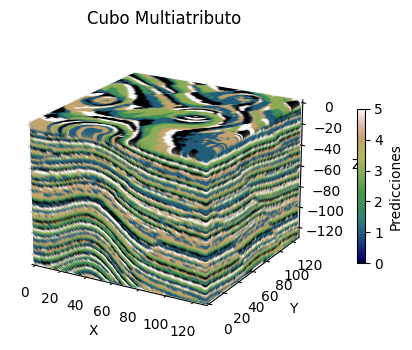

In [36]:
grafico_3d_facies(array_3d,'Cubo Multiatributo',dataframe.facies.values)


**Autores**



*   [*Lucía Páez Gayone*](https://www.linkedin.com/in/luc%C3%ADa-p%C3%A1ez-gayone-10b5252b1/) Geofísica
*   [*Yosmely Bermúdez*](https://www.linkedin.com/in/yosmely-bermudez/) Ingeniera Geofísica
*   [*Felipe Carol Corbetta*](https://www.linkedin.com/in/felipe-corbetta-geof/) Geofísico
*   [*Nicolás Agustín Guardo*](https://www.linkedin.com/in/nicolas-guardo) Geólogo



